- 코르크 질량 막대 1, 2, 3, 4에 대한
    - 질량
    - 수직항력(중력)
    - 느림 최대정지마찰력
    - 느림 운동마찰력
    - 빠름 최대정지마찰력
    - 빠름 운동마찰력

- 코르크, 펠트, 플라스틱 막대 4에 대한
    - 질량
    - 수직항력(중력)
    - 느림 최대정지마찰력
    - 느림 운동마찰력
    - 빠름 최대정지마찰력
    - 빠름 운동마찰력

- 펠트 트레인, 펠트 스택에 대한
    - 질량
    - 수직항력(중력)
    - 최대정지마찰력
    - 운동마찰력

- 힘-시간 그래프 사진  
- 파이썬 코드 (주석도)

In [1]:
from dataclasses import dataclass   # 쉽고 빠르게 클래스를 만들 수 있는 파이썬 내장 모듈
from enum import Enum   # 열거형을 만들 수 있게 해주는 파이썬 내장 모듈
from os import path     # 파일 경로를 쉽게 조작할 수 있게 해주는 파이썬 내장 모듈
import pandas as pd     # 엑셀과 같은 테이블 형태의 자료구조를 지원하는 외장 모듈
import numpy as np      # 매우 빠르고 편한 다차원 배열을 지원하는 외장 모듈
import matplotlib.pyplot as plt     # 쉽게 그래프를 그릴 수 있게 해주는 외장 모듈

In [2]:
# 재질.
class Material(Enum):   
    CORK = 0,
    FELT = 1,
    PLASTIC = 2

# 마찰 수레. 질량과 재질 특성을 가진다.
@dataclass
class Tray:
    mass: float
    material: Material

# 질량 막대. 질량 특성만을 가진다.
@dataclass
class MassBar:
    mass: float

# 그래프에서 최댓값(최대정지마찰력)을 뽑을 시간 범위와, 평균값(운동마찰력)을 뽑을 시간 범위를 저장하는 클래스.
@dataclass
class Range:
    max: tuple[float, float]
    mean: tuple[float, float]

# 하나의 실험을 통째로 정의하는 클래스.
# - 마찰 수레가 어느 것이 쓰였는지
# - 질량 막대가 어느 것이 쓰였는지
# - 실험 결과 데이터 엑셀 파일이 어디에 있는지
# - 데이터 엑셀 파일에서 어느 Run 데이터를 사용해야 하는지
# 를 이용해서
# 시간, 힘, 변위, 속력, 가속력을 저장하는 테이블과 최댓값, 평균값 범위 지정용 Range 클래스와 그래프를 그려주고 자동으로 폴더에 데이터를 저장하는 기능 존재
class Experiment:
    # 하나의 실험을 정의하는 데 사용되는 함수
    def __init__(self, trays: tuple[Tray, ...], data_path: str, mass_bars: tuple[MassBar, ...], run_no: tuple[int, ...]):
        self.trays = trays
        self.mass_bars = mass_bars
        self.runs = {}
        self.ranges = {}
        
        df = pd.read_csv(path.join('..', '원본 데이터', data_path))
        column_names = {
            'Time (s)': 't',
            'Force (N)': 'F',
            'Position (m)': 'x',
            'Velocity (m/s)': 'v',
            'Acceleration (m/s²)': 'a'
        }

        for column in df.columns:
            name, no = column.strip().split('Run #')
            name, no = name.strip(), int(no)

            if no not in run_no:
                continue

            if no not in self.runs:
                self.runs[no] = pd.DataFrame()

            self.runs[no][column_names[name]] = df[column]
        
        for no in self.runs:
            self.runs[no].F *= -1
            self.ranges[no] = Range((0, self.runs[no].t.max()), (0, self.runs[no].t.max()))

    # 이 실험은 총 몇 번의 Run으로 이루어져 있는지 알려주는 함수
    def __len__(self):
        return len(self.runs)
    
    # 인자로 넣은 Run 번호의 데이터를 반환해주는 함수
    def __getitem__(self, item: int):
        return self.runs[item]

    # 인자로 넣은 Run 번호들의 그래프를 그려준다. 아무 것도 안 넣으면 다 그려준다. fig_name을 정의해주면 그 경로로 직접 그래프 그림과 데이터가 저장된다.
    def __call__(self, *no_list: tuple[int, ...], fig_name: str = None) -> pd.DataFrame:
        count = len(no_list) if no_list else len(self)
        
        fig, axis = plt.subplots(1, count, figsize=(5 * count, 5))
        ret = pd.DataFrame(columns=['질량', '중력', '최대정지마찰력', '운동마찰력', '정지마찰계수', '운동마찰계수'])

        # F-t 그래프
        for i, no in enumerate(self.runs.keys()):
            if no_list and no not in no_list:
                continue
            
            if count != 1:
                ax = axis[i]
            else:
                ax = axis
            
            run = self.runs[no]
            max_range, mean_range = self.ranges[no].max, self.ranges[no].mean
            
            max_f = run[(max_range[0] <= run.t) & (run.t <= max_range[1])].F.max()
            max_f_t = run.t[run.F == max_f].iloc[0]
            mean_f = run[(mean_range[0] <= run.t) & (run.t <= mean_range[1])].F.mean()
            # mean_f_t = run.t.loc[abs(run.F - mean_f).idxmin()]
            
            mass = sum(tray.mass for tray in self.trays) + sum(bar.mass for bar in self.mass_bars)
            normal = mass * 9.8
            ret.loc[len(ret)] = [mass, normal, max_f, mean_f, max_f / normal, mean_f / normal]

            ax.plot(run.t, run.F)
            
            ax.axvspan(max_range[0], max_range[1], color='orange', alpha=0.3)
            ax.axvspan(mean_range[0], mean_range[1], color='magenta', alpha=0.3)
            
            ax.axhline(max_f, color='orange', linestyle='--')
            ax.text(x=0, y=max_f-0.2, s=f'{max_f:.2f} N', color='orange')
            ax.axhline(mean_f, color='magenta', linestyle='--')
            ax.text(x=0, y=mean_f-0.2, s=f'{mean_f:.2f} N', color='magenta')
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Force (N)')
            ax.set_title(f'Run #{no}')
            ax.grid()
        
        if fig_name:
            plt.savefig(path.join('..', '정제 데이터', f'{fig_name}.png'))
            ret.to_csv(path.join('..', '정제 데이터', f'{fig_name}.csv'), index=False, encoding="utf-8-sig")

        return ret

In [3]:
# 특정 실험의 특정 Run의 평균 속력을 구해주는 함수
def v_mean(experiment: Experiment, index: int):
    mean_range = experiment.ranges[index].mean
    df = experiment[index]

    return df[(mean_range[0] <= df.t) & (df.t <= mean_range[1])].v.mean()

# 특정 실험의 모든 Run의 평균 속력을 구해주는 함수
def all_v_mean(experiment: Experiment):
    return [v_mean(experiment, key) for key in experiment.runs.keys()]

In [5]:
# 마찰 수레들 정의, 첫 번째 인자는 무게(kg), 두 번째 인자는 재질
cork = Tray(94 / 1000, Material.CORK)
felt1 = Tray(84.4 / 1000, Material.FELT)
felt2 = Tray(84.6 / 1000, Material.FELT)
plastic = Tray(97.6 / 1000, Material.PLASTIC)

# 질량 막대들 정의, 인자는 무게(kg)만
mass1 = MassBar(253 / 1000)
mass2 = MassBar(248.2 / 1000)
mass3 = MassBar(253 / 1000)
mass4 = MassBar(247.3 / 1000)

cork_slow1
- 코르크 마찰 수레
- 질량 막대 1개
- 느리게

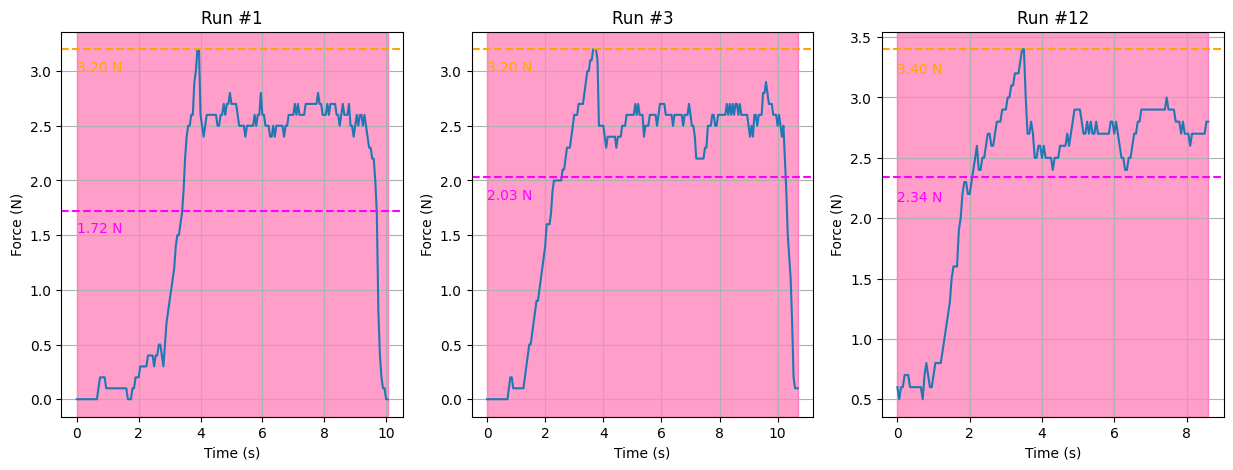

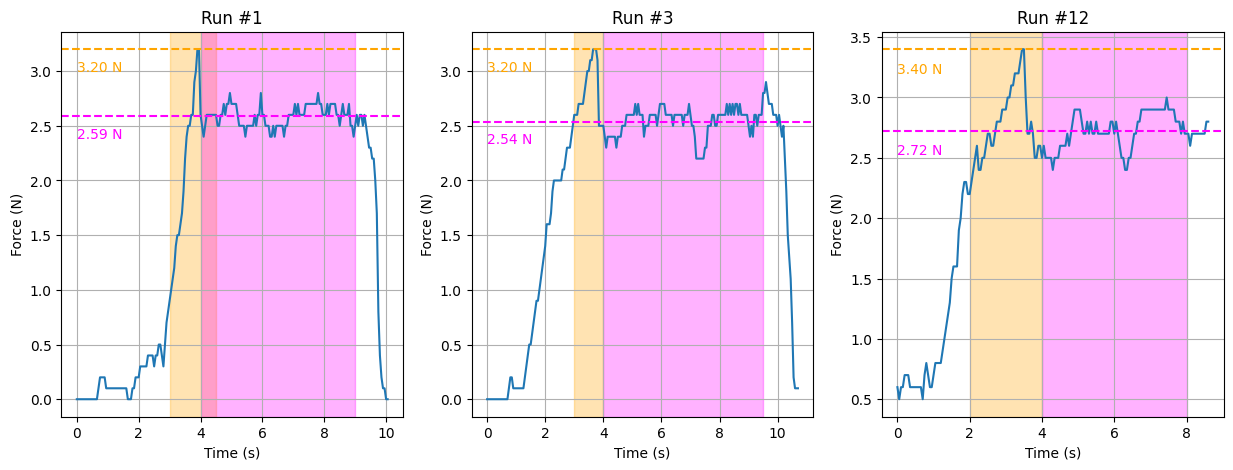

In [9]:
cork_slow1 = Experiment((cork, ), '느리게.csv', (mass1, ), (1, 3, 12)) # 2 제외

cork_slow1()
cork_slow1.ranges[1] = Range(max=(3, 4.5), mean=(4, 9))
cork_slow1.ranges[3] = Range(max=(3, 4), mean=(4, 9.5))
cork_slow1.ranges[12] = Range(max=(2, 4), mean=(4, 8))
data = cork_slow1(fig_name='cork_slow1')

In [7]:
all_v_mean(cork_slow1)

[0.10217821782178216, 0.08099099099099095, 0.10407407407407407]

ValueError: x and y must have same first dimension, but have shapes (1,) and (275,)

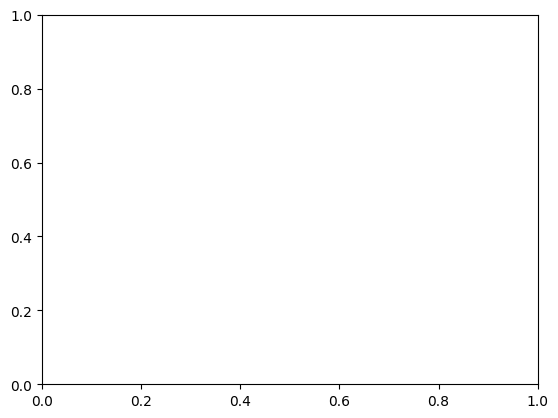

In [14]:
plt.plot(data.중력[0], cork_slow1.runs[1].F)

cork_slow2
- 코르크 마찰 수레
- 질량 막대 2개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,0.5952,5.83296,5.3,4.408197,0.908630,0.755739
1,0.5952,5.83296,5.6,4.440741,0.960061,0.761319
2,0.5952,5.83296,5.5,4.427869,0.942917,0.759112


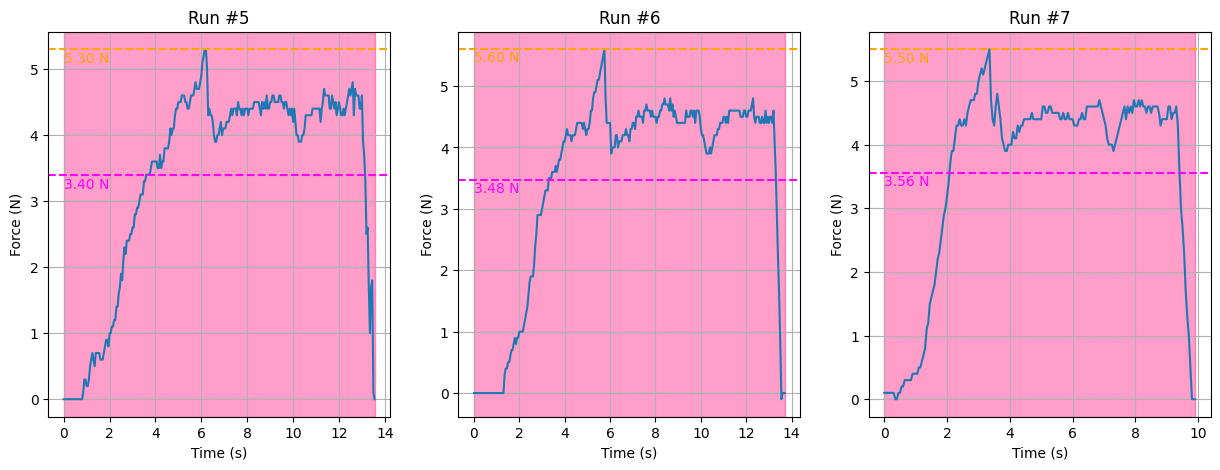

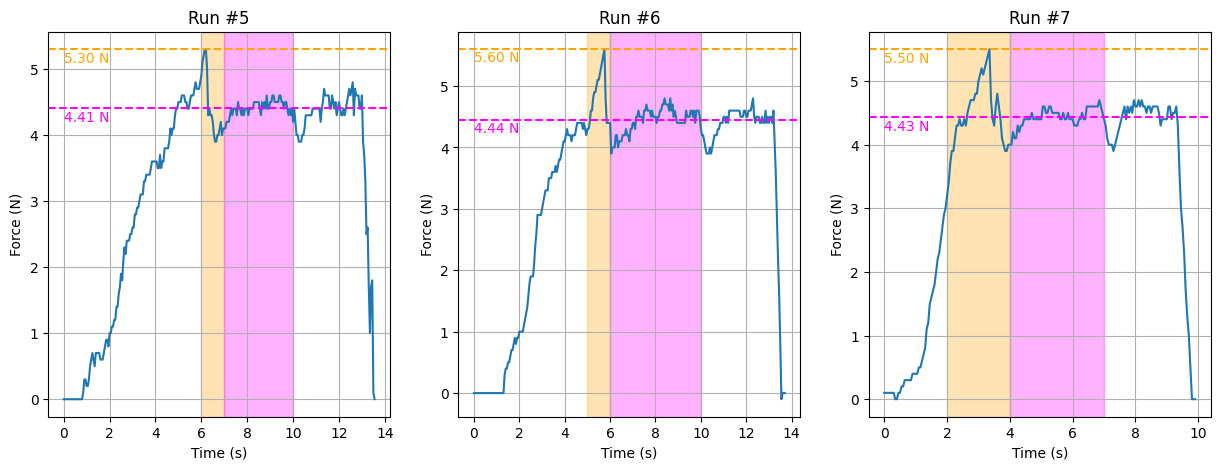

In [7]:
cork_slow2 = Experiment((cork, ), '느리게.csv', (mass1, mass2), (5, 6, 7))  # 4 제외

cork_slow2()
cork_slow2.ranges[5] = Range(max=(6, 7), mean=(7, 10))
cork_slow2.ranges[6] = Range(max=(5, 6), mean=(6, 10))
cork_slow2.ranges[7] = Range(max=(2, 4), mean=(4, 7))
cork_slow2(fig_name='cork_slow2')

In [8]:
all_v_mean(cork_slow2)

[0.06524590163934427, 0.06135802469135803, 0.06770491803278689]

cork_slow3
- 코르크 마찰 수레
- 질량 막대 3개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,0.8482,8.31236,7.3,5.870297,0.878210,0.706213
1,0.8482,8.31236,7.4,6.428395,0.890241,0.773354
2,0.8482,8.31236,7.7,6.521951,0.926331,0.784609


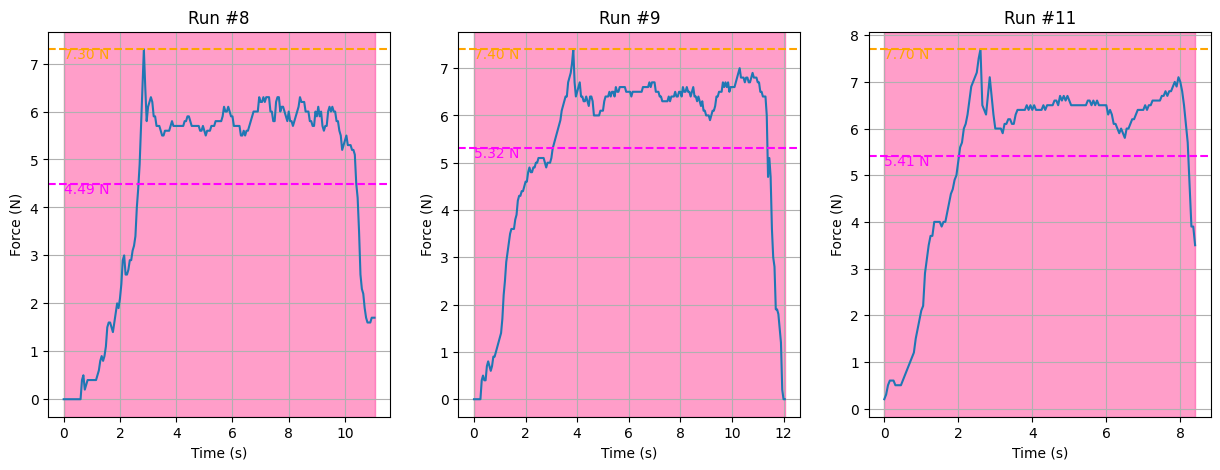

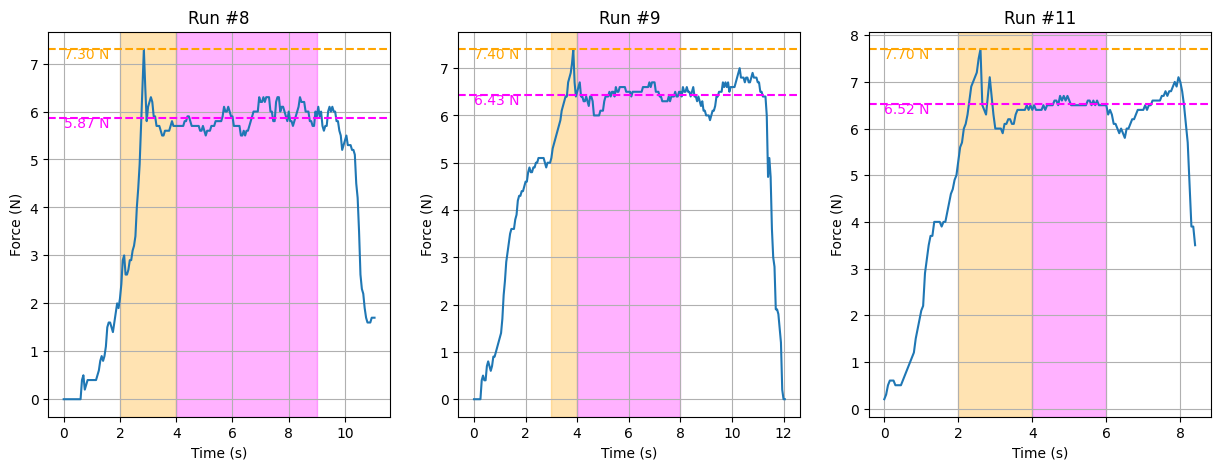

In [9]:
cork_slow3 = Experiment((cork, ), '느리게.csv', (mass1, mass2, mass3), (8, 9, 11)) # 10 제외

cork_slow3()
cork_slow3.ranges[8] = Range(max=(2, 4), mean=(4, 9))
cork_slow3.ranges[9] = Range(max=(3, 4), mean=(4, 8))
cork_slow3.ranges[11] = Range(max=(2, 4), mean=(4, 6))
cork_slow3(fig_name='cork_slow3')

In [10]:
all_v_mean(cork_slow3)

[0.06900990099009903, 0.059506172839506176, 0.07073170731707318]

cork_slow4
- 코르크 마찰 수레
- 질량 막대 4개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0955,10.7359,9.2,7.913115,0.856938,0.737070
1,1.0955,10.7359,10.0,8.093443,0.931454,0.753867


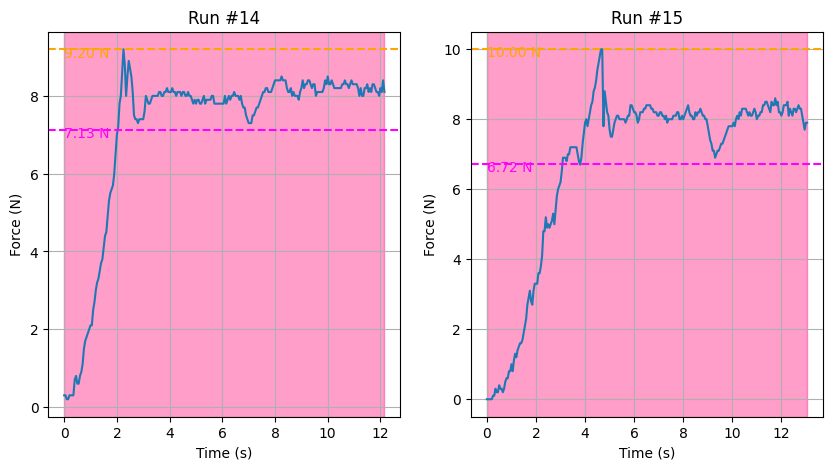

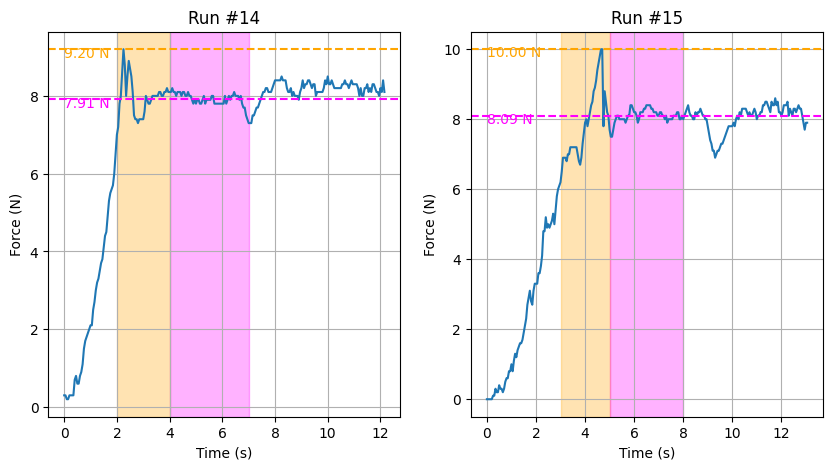

In [11]:
cork_slow4 = Experiment((cork, ), '느리게.csv', (mass1, mass2, mass3, mass4), (14, 15)) # 13 제외

cork_slow4()
cork_slow4.ranges[14] = Range(max=(2, 4), mean=(4, 7))
cork_slow4.ranges[15] = Range(max=(3, 5), mean=(5, 8))
cork_slow4(fig_name='cork_slow4')

In [12]:
all_v_mean(cork_slow4)

[0.05065573770491804, 0.06459016393442622]

cork_fast1
- 코르크 마찰 수레
- 질량 막대 1개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,0.347,3.4006,3.1,2.467742,0.911604,0.725678
1,0.347,3.4006,2.9,2.253659,0.852791,0.662724
2,0.347,3.4006,3.5,2.380488,1.029230,0.700020


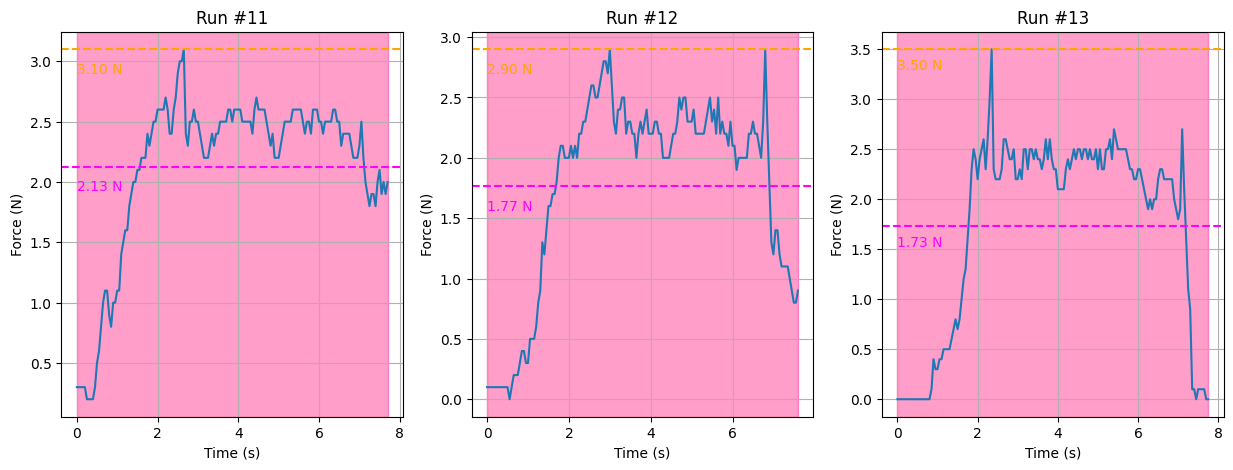

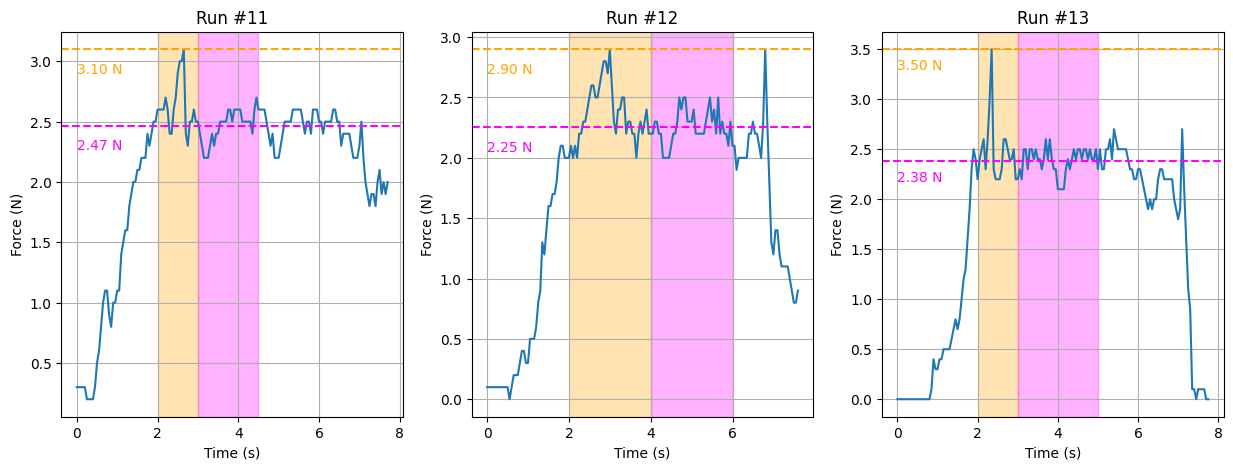

In [13]:
cork_fast1 = Experiment((cork, ), '빠르게.csv', (mass1, ), (11, 12, 13))

cork_fast1()
cork_fast1.ranges[11] = Range(max=(2, 3), mean=(3, 4.5))
cork_fast1.ranges[12] = Range(max=(2, 4), mean=(4, 6))
cork_fast1.ranges[13] = Range(max=(2, 3), mean=(3, 5))
cork_fast1(fig_name='cork_fast1')

In [14]:
all_v_mean(cork_fast1)

[0.13483870967741934, 0.22707317073170738, 0.15414634146341463]

cork_fast2
- 코르크 마찰 수레
- 질량 막대 2개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,0.5952,5.83296,5.7,4.365574,0.977205,0.748432
1,0.5952,5.83296,5.7,4.444262,0.977205,0.761922


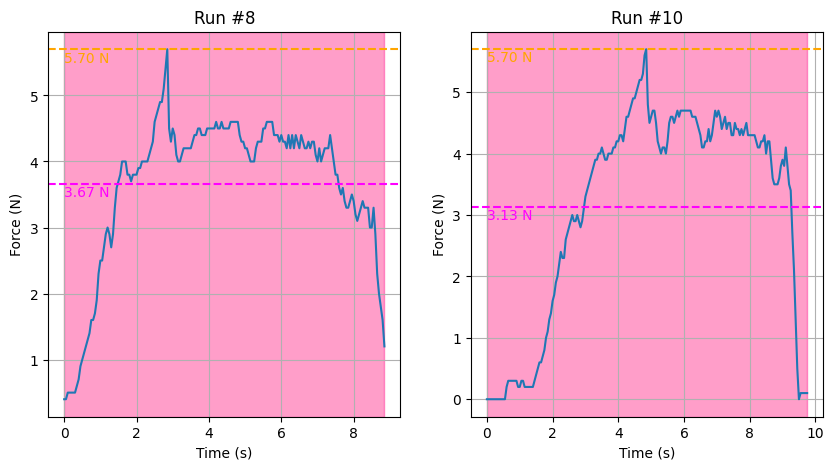

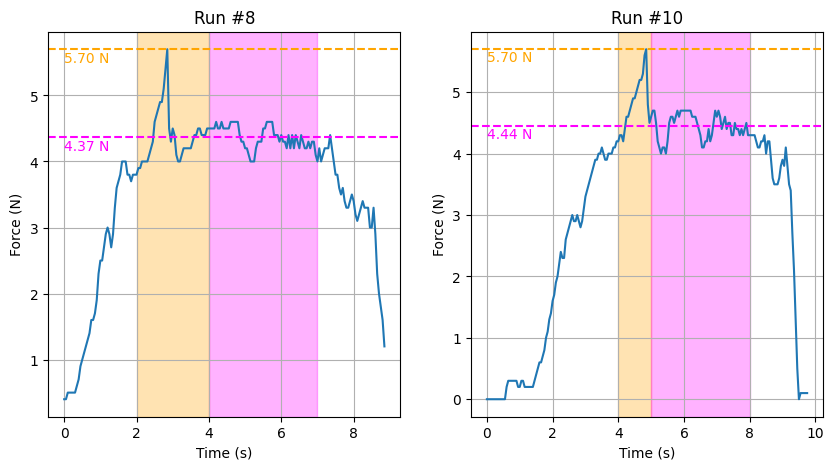

In [15]:
cork_fast2 = Experiment((cork, ), '빠르게.csv', (mass1, mass2), (8, 10))   # 9 제외

cork_fast2()
cork_fast2.ranges[8] = Range(max=(2, 4), mean=(4, 7))
cork_fast2.ranges[10] = Range(max=(4, 5), mean=(5, 8))
cork_fast2(fig_name='cork_fast2')

In [16]:
all_v_mean(cork_fast2)

[0.13639344262295086, 0.18393442622950815]

cork_fast3
- 코르크 마찰 수레
- 질량 막대 3개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,0.8482,8.31236,7.9,6.411268,0.950392,0.771293
1,0.8482,8.31236,7.3,6.372131,0.878210,0.766585
2,0.8482,8.31236,7.0,6.119753,0.842119,0.736223


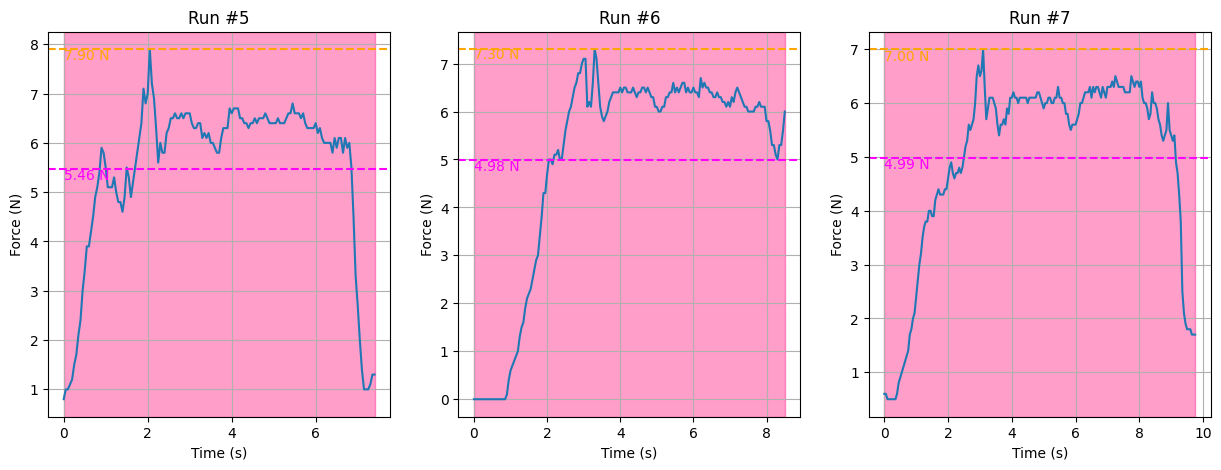

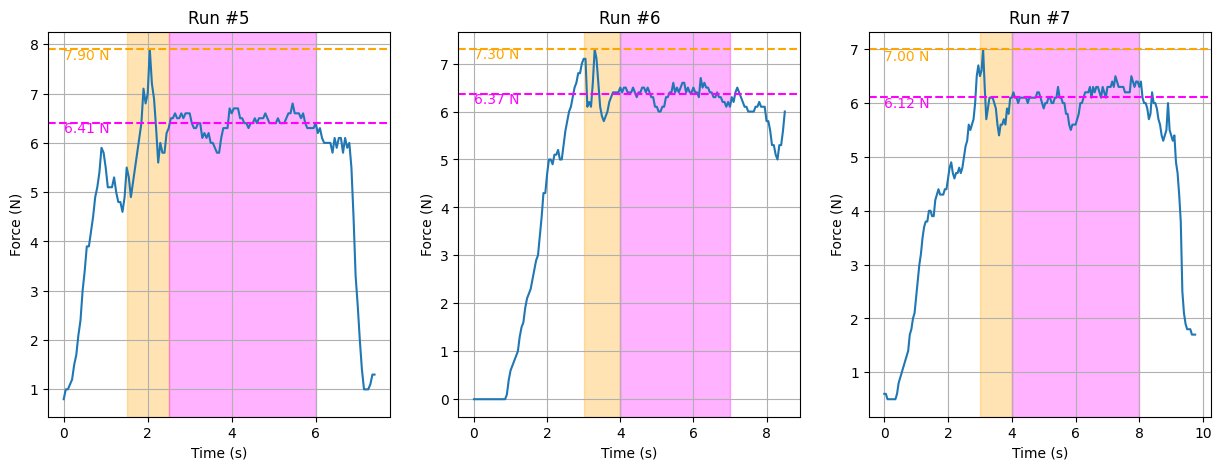

In [17]:
cork_fast3 = Experiment((cork, ), '빠르게.csv', (mass1, mass2, mass3), (5, 6, 7))   # 4 제외

cork_fast3()
cork_fast3.ranges[5] = Range(max=(1.5, 2.5), mean=(2.5, 6))
cork_fast3.ranges[6] = Range(max=(3, 4), mean=(4, 7))
cork_fast3.ranges[7] = Range(max=(3, 4), mean=(4, 8))
cork_fast3(fig_name='cork_fast3')

In [18]:
all_v_mean(cork_fast3)

[0.1559154929577465, 0.14573770491803276, 0.1288888888888889]

cork_fast4
- 코르크 마찰 수레
- 질량 막대 4개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0955,10.7359,9.2,7.806173,0.856938,0.727109
1,1.0955,10.7359,10.0,8.049550,0.931454,0.749779


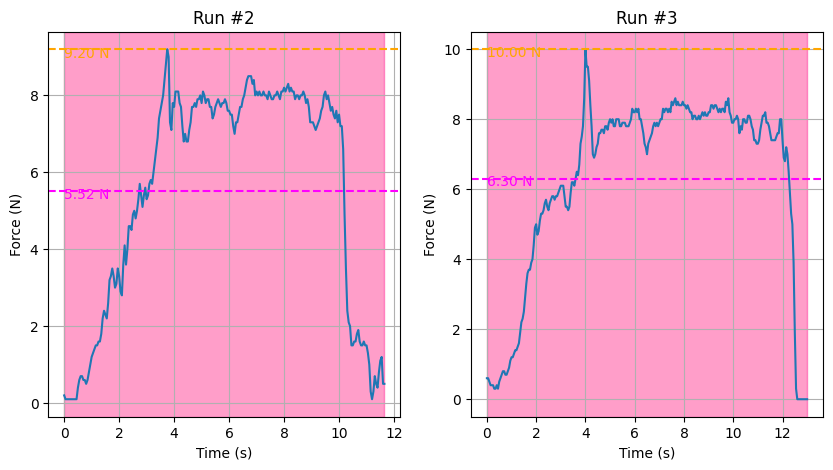

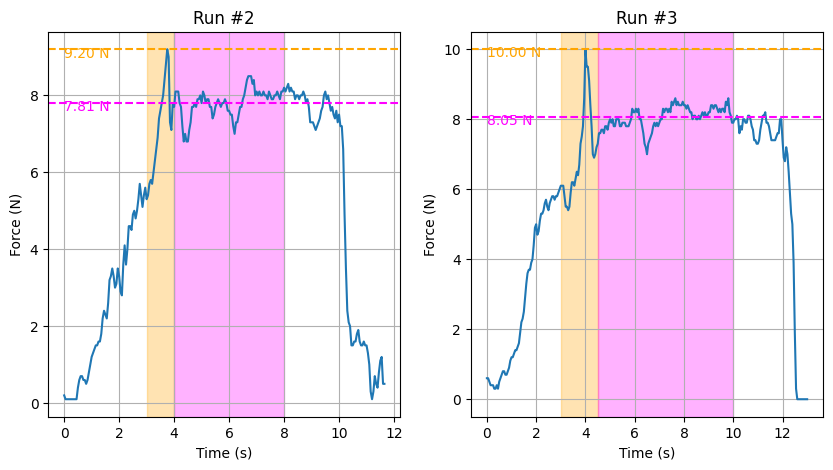

In [19]:
cork_fast4 = Experiment((cork, ), '빠르게.csv', (mass1, mass2, mass3, mass4), (2, 3))   # 1 제외

cork_fast4()
cork_fast4.ranges[2] = Range(max=(3, 4), mean=(4, 8))
cork_fast4.ranges[3] = Range(max=(3, 4.5), mean=(4.5, 10))
cork_fast4(fig_name='cork_fast4')

In [20]:
all_v_mean(cork_fast4)

[0.13728395061728396, 0.08963963963963964]

felt_slow4
- 펠트 마찰 수레
- 질량 막대 4개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0859,10.64182,3.9,3.844628,0.366479,0.361275
1,1.0859,10.64182,3.8,3.740594,0.357082,0.351499
2,1.0859,10.64182,3.9,3.880198,0.366479,0.364618


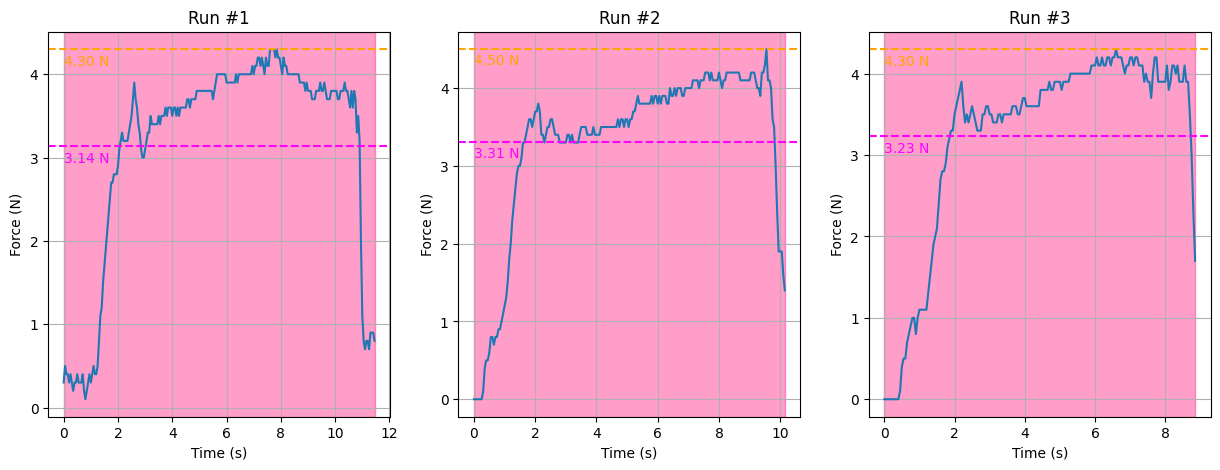

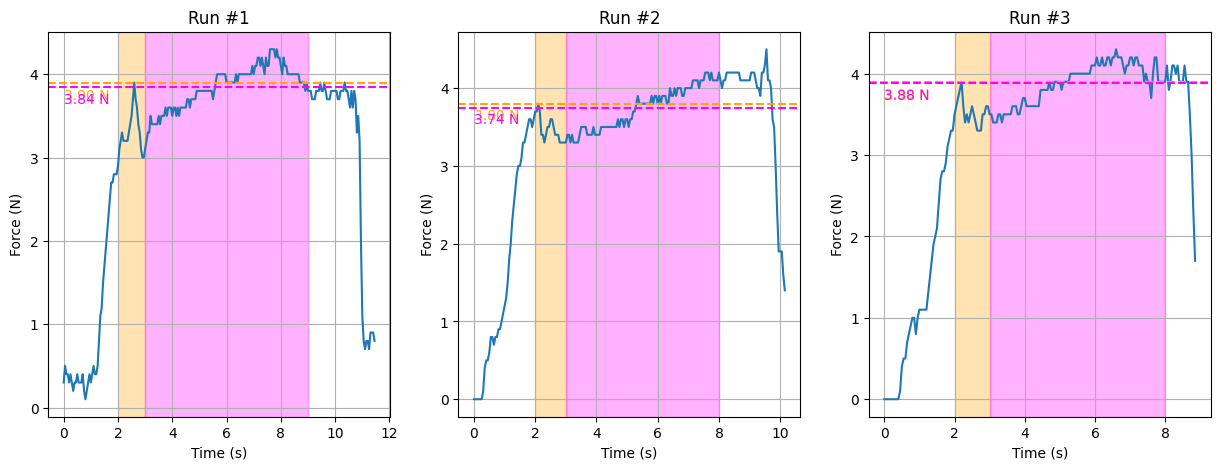

In [21]:
felt_slow4 = Experiment((felt1, ), 'felt slow&fast.csv', (mass1, mass2, mass3, mass4), (1, 2, 3))

felt_slow4()
felt_slow4.ranges[1] = Range(max=(2, 3), mean=(3, 9))
felt_slow4.ranges[2] = Range(max=(2, 3), mean=(3, 8))
felt_slow4.ranges[3] = Range(max=(2, 3), mean=(3, 8))
felt_slow4(fig_name='felt_slow4')

In [22]:
all_v_mean(felt_slow4)

[0.04380165289256198, 0.039009900990099, 0.05861386138613861]

felt_fast4
- 펠트 마찰 수레
- 질량 막대 4개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0859,10.64182,5.5,3.981481,0.516829,0.374135
1,1.0859,10.64182,3.8,4.061386,0.357082,0.381644
2,1.0859,10.64182,4.4,3.993827,0.413463,0.375296


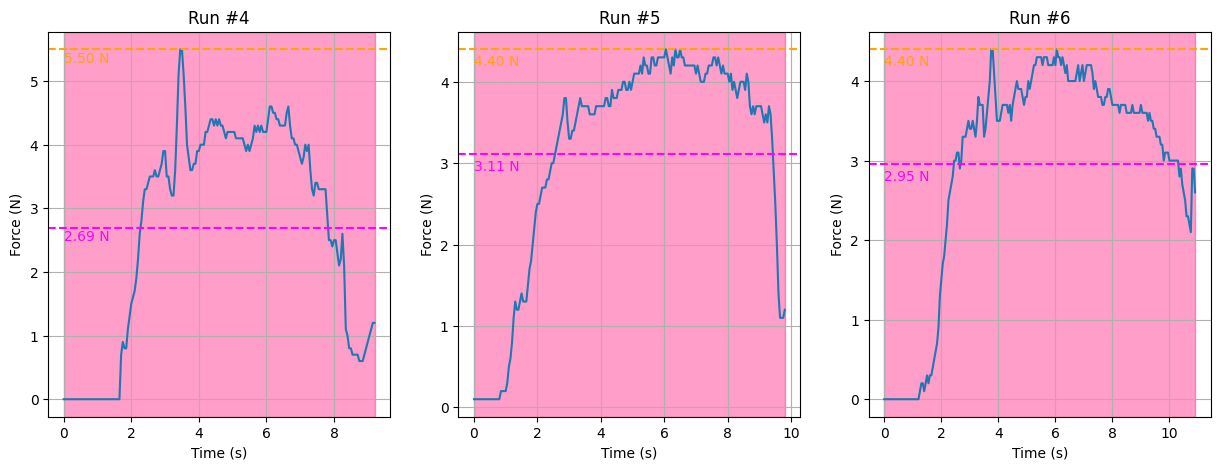

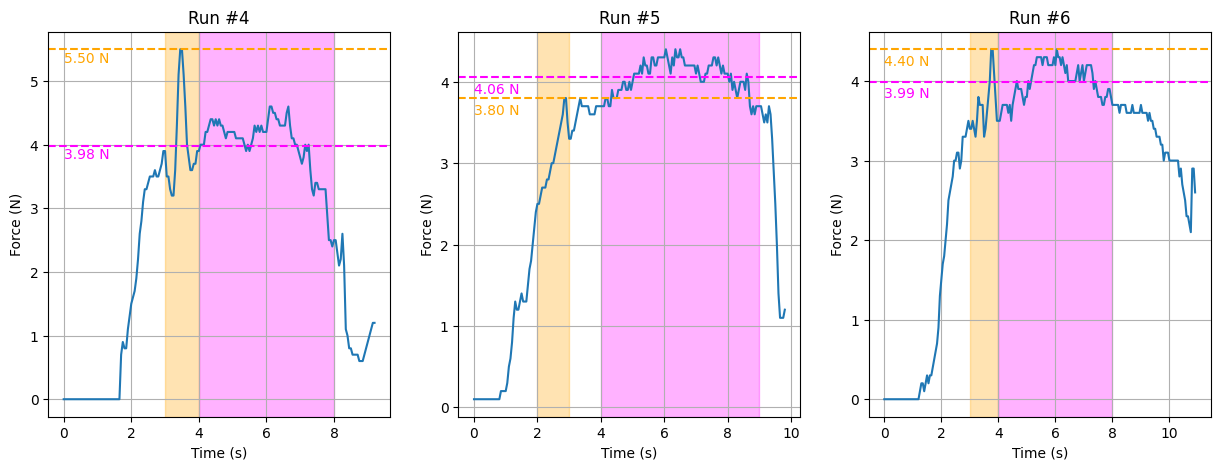

In [23]:
felt_fast4 = Experiment((felt1, ), 'felt slow&fast.csv', (mass1, mass2, mass3, mass4), (4, 5, 6))

felt_fast4()
felt_fast4.ranges[4] = Range(max=(3, 4), mean=(4, 8))
felt_fast4.ranges[5] = Range(max=(2, 3), mean=(4, 9))
felt_fast4.ranges[6] = Range(max=(3, 4), mean=(4, 8))
felt_fast4(fig_name='felt_fast4')

In [24]:
all_v_mean(felt_fast4)

[0.14851851851851852, 0.11237587326732673, 0.12592592592592594]

plastic_slow4
- 플라스틱 마찰 수레
- 질량 막대 4개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0991,10.77118,2.4,1.466337,0.222817,0.136135
1,1.0991,10.77118,2.2,1.560331,0.204249,0.144862
2,1.0991,10.77118,2.0,1.596703,0.185681,0.148238


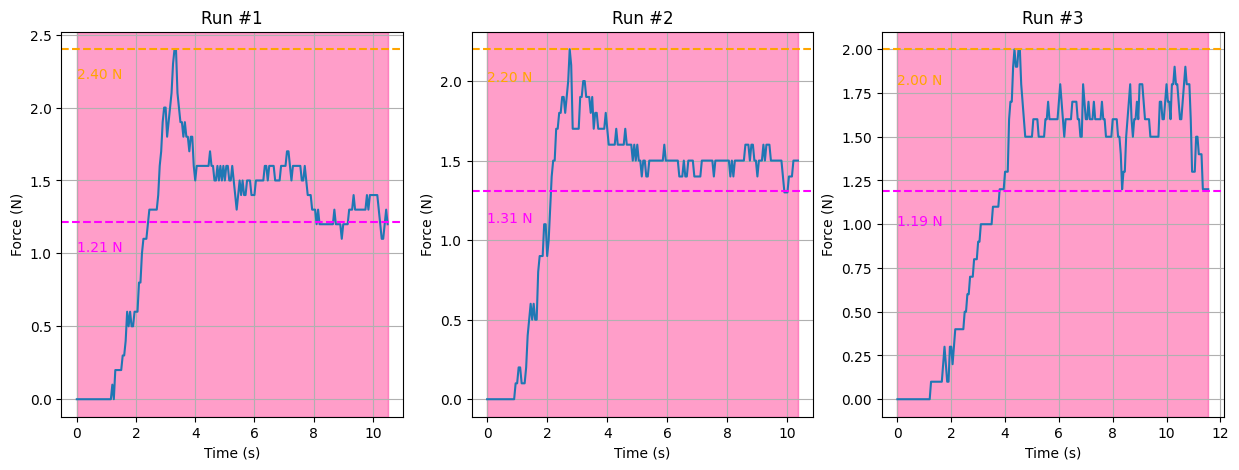

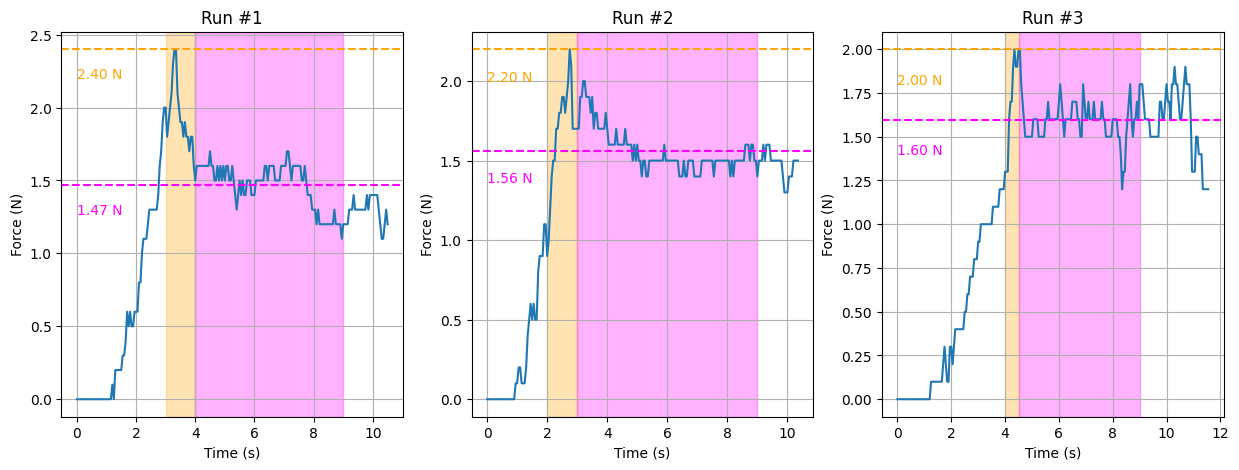

In [25]:
plastic_slow4 = Experiment((plastic, ), 'plastic slow&fast.csv', (mass1, mass2, mass3, mass4), (1, 2, 3))

plastic_slow4()
plastic_slow4.ranges[1] = Range(max=(3, 4), mean=(4, 9))
plastic_slow4.ranges[2] = Range(max=(2, 3), mean=(3, 9))
plastic_slow4.ranges[3] = Range(max=(4, 4.5), mean=(4.5, 9))
plastic_slow4(fig_name='plastic_slow4')

In [26]:
all_v_mean(plastic_slow4)

[0.05831683168316831, 0.04801652892561985, 0.05824175824175825]

plastic_fast4
- 플라스틱 마찰 수레
- 질량 막대 4개
- 빠르게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.0991,10.77118,2.7,1.637037,0.250669,0.151983
1,1.0991,10.77118,3.0,1.627869,0.278521,0.151132
2,1.0991,10.77118,2.7,1.854902,0.250669,0.172210


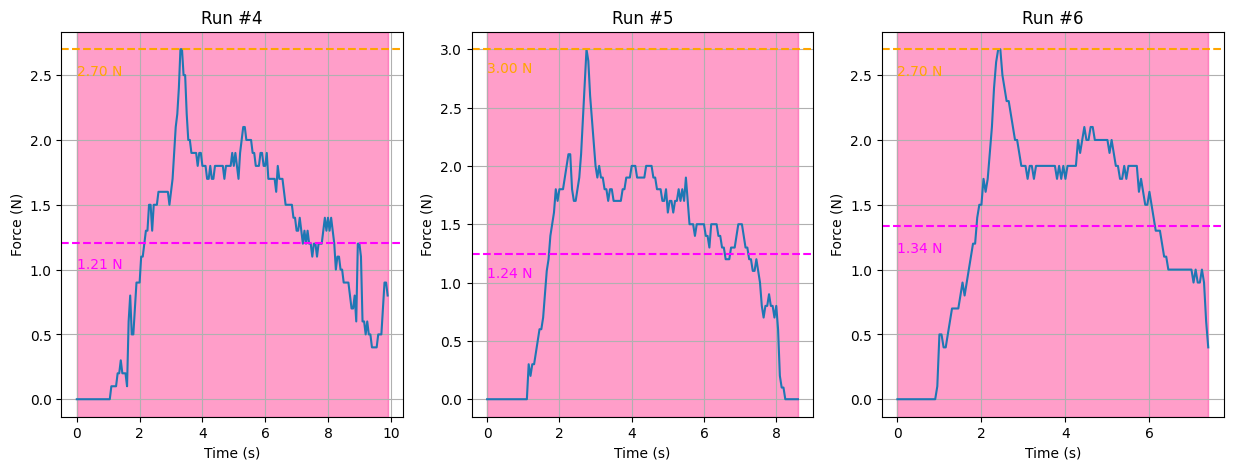

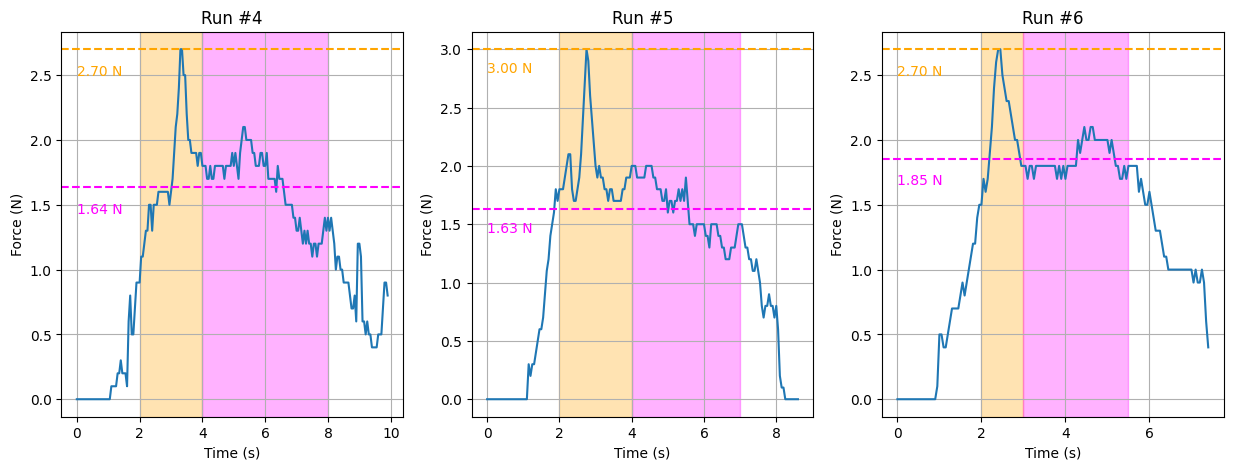

In [27]:
plastic_fast4 = Experiment((plastic, ), 'plastic slow&fast.csv', (mass1, mass2, mass3, mass4), (4, 5, 6))

plastic_fast4()
plastic_fast4.ranges[4] = Range(max=(2, 4), mean=(4, 8))
plastic_fast4.ranges[5] = Range(max=(2, 4), mean=(4, 7))
plastic_fast4.ranges[6] = Range(max=(2, 3), mean=(3, 5.5))
plastic_fast4(fig_name='plastic_fast4')

In [28]:
all_v_mean(plastic_fast4)

[0.1319753086419753, 0.13688524590163936, 0.13549019607843138]

train
- 펠트 마찰 수레 2개를 트레인으로
- 질량 막대 4개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.1705,11.4709,4.9,3.981188,0.427168,0.347069
1,1.1705,11.4709,4.4,3.705674,0.383579,0.323050


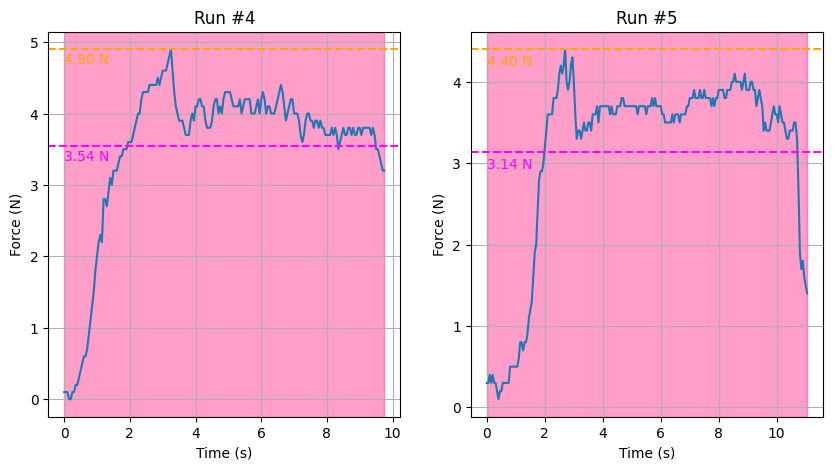

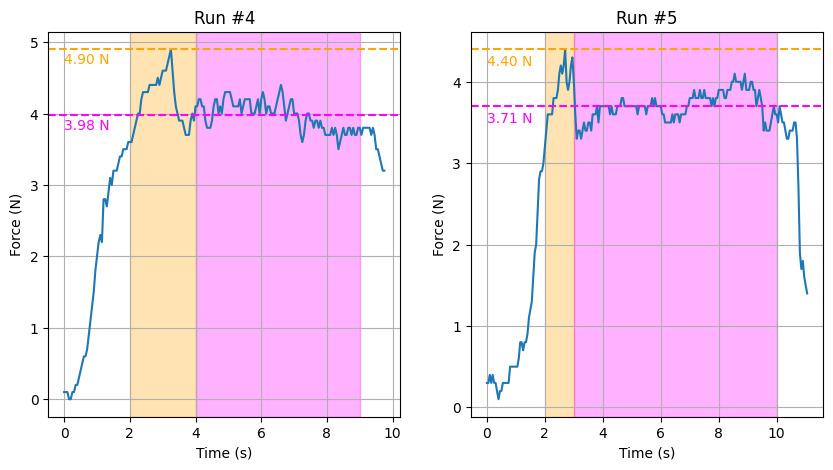

In [29]:
train = Experiment((felt1, felt2), 'stack&train.csv', (mass1, mass2, mass3, mass4), (4, 5)) # 6 제외

train()
train.ranges[4] = Range(max=(2, 4), mean=(4, 9))
train.ranges[5] = Range(max=(2, 3), mean=(3, 10))
train(fig_name='train')

In [30]:
all_v_mean(train)

[0.08594059405940593, 0.07304964539007093]

stack
- 펠트 마찰 수레 2개를 스택으로
- 질량 막대 4개
- 느리게

,질량,중력,최대정지마찰력,운동마찰력,정지마찰계수,운동마찰계수
0,1.1705,11.4709,4.7,3.971930,0.409732,0.346261
1,1.1705,11.4709,4.7,3.979433,0.409732,0.346915
2,1.1705,11.4709,4.5,4.006832,0.392297,0.349304


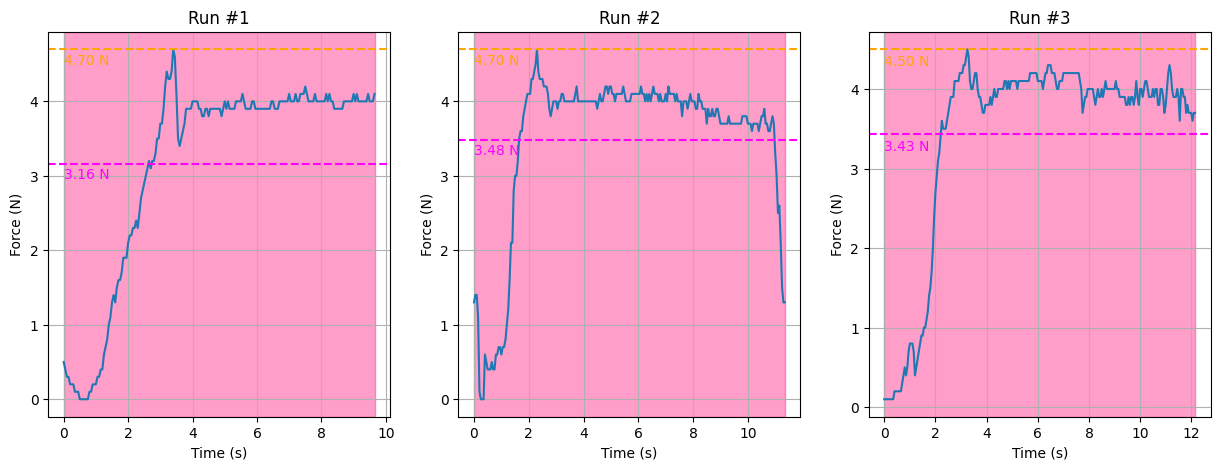

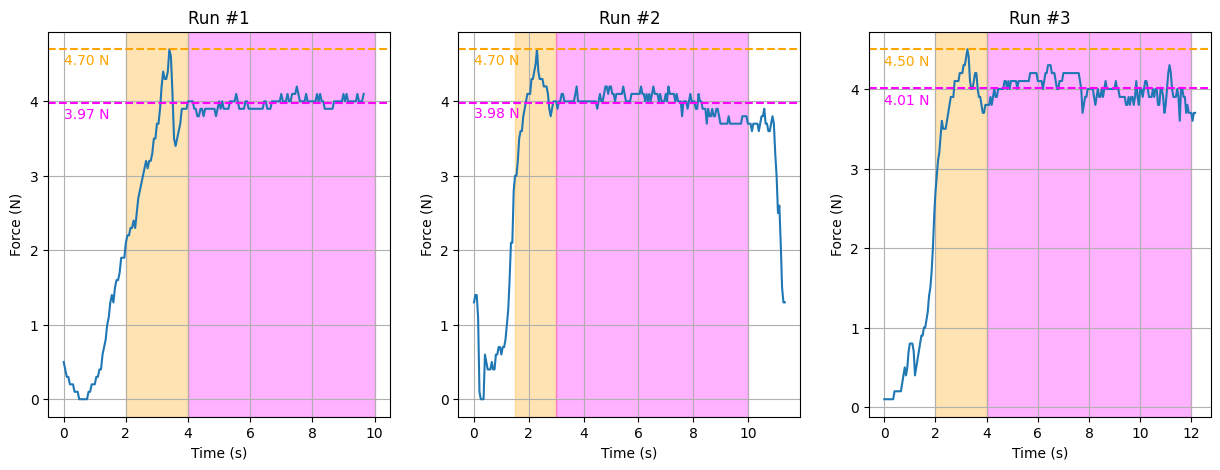

In [31]:
stack = Experiment((felt1, felt2), 'stack&train.csv', (mass1, mass2, mass3, mass4), (1, 2, 3))

stack()
stack.ranges[1] = Range(max=(2, 4), mean=(4, 10))
stack.ranges[2] = Range(max=(1.5, 3), mean=(3, 10))
stack.ranges[3] = Range(max=(2, 4), mean=(4, 12))
stack(fig_name='stack')

In [32]:
all_v_mean(stack)

[0.035405405405405405, 0.05092198581560284, 0.062173913043478274]